In [168]:
# Pandas library for the pandas dataframes
import pandas as pd
from pandas import DataFrame
import numpy as np
import scipy.stats as stats
import scipy

# Import Scikit-Learn library for decision tree models
import sklearn 

from sklearn import datasets, linear_model, metrics, tree
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso,  RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
        
# Dataset splitting        
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_validate, RandomizedSearchCV

# Errors
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm

import os
import joblib

In [160]:
df_abs = pd.read_csv("dataset_scaled_abs.csv")
df_abs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 80 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Unnamed: 0                                     205 non-null    int64  
 1   in_amount_mmol                                 205 non-null    float64
 2   p_amount_mmol                                  205 non-null    float64
 3   ligand_amount_mmol                             205 non-null    float64
 4   first_sol_amount_ml                            205 non-null    float64
 5   second_sol_amount_ml                           205 non-null    float64
 6   third_sol_amount_ml                            205 non-null    float64
 7   other_1_amount_mmol                            205 non-null    float64
 8   other_2_amount_mmol                            205 non-null    float64
 9   total_volume_ml                                205 non

In [161]:
#Checks the column names, and ensures that they do not have any leading or trailing spaces
df_abs.columns = df_abs.columns.str.strip()

In [162]:
# Input for ML models

input_col = ['in_amount_mmol', 'p_amount_mmol', 'ligand_amount_mmol', 'first_sol_amount_ml', 'second_sol_amount_ml', 
             'third_sol_amount_ml', 'other_1_amount_mmol', 'other_2_amount_mmol', 'total_volume_ml', 
             'temp_c', 'time_min', 'x0_chloroindium oxalate', 'x0_indium acetate', 'x0_indium bromide', 
             'x0_indium chloride', 'x0_indium iodide', 'x0_indium myristate', 'x0_indium oxalate', 
             'x0_indium palmitate', 'x0_indium trifluoroacetate', 'x0_indium tris(N,N-diisopropylacetamidinato)', 
             'x1_bis(trimethylsilyl)phosphine', 'x1_phosphine gas', 'x1_phosphorus trichloride', 'x1_sodium phosphide', 
             'x1_tris(diethylamino)phosphine', 'x1_tris(dimethylamino)phosphine', 'x1_tris(trimethylgermyl)phosphine', 
             'x1_tris(trimethylsilyl)phosphine', 'x1_white phosphorus', 'x2_None', 'x2_dodecanethiol', 
             'x2_lauric acid', 'x2_myristic acid', 'x2_oleic acid', 'x2_palmitic acid', 'x2_stearic acid', 
             'x3_4-ethylpyridine', 'x3_None', 'x3_dimethylformamide', 'x3_dodecylamine', 'x3_mesitylene', 
             'x3_octadecene', 'x3_oleylamine', 'x3_trioctylamine', 'x3_trioctylphosphine', 'x3_trioctylphosphine oxide', 
             'x4_None', 'x4_dioctyl ether', 'x4_dioctylamine', 'x4_hexadecylamine', 'x4_hexadecylamine', 
             'x4_octylamine', 'x4_oleylamine', 'x4_toluene', 'x4_trioctylphosphine', 'x4_trioctylphosphine oxide', 
             'x5_None', 'x5_trioctylphosphine', 'x6_None', 'x6_acetic acid', 'x6_superhydride', 
             'x6_tetrabutylammonium myristate', 'x6_zinc acetate', 'x6_zinc bromide', 'x6_zinc chloride', 
             'x6_zinc iodide', 'x6_zinc octanoate', 'x6_zinc oleate', 'x6_zinc stearate', 'x6_zinc undecylenate', 
             'x7_None', 'x7_copper bromide', 'x7_oleic acid', 'x7_water', 'x7_zinc iodide']

output_col = ['abs_nm']

X = df_abs[input_col]

Y = df_abs[output_col]

In [163]:
# Splitting dataset for training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=45, shuffle=True)

# Hyper parameter tuning

### Bagging

In [ ]:
%%time

#sklearn random search over n iterations
#the internet tunes these 5 parameters for bagging

params = {'n_estimators': range(10,1001),
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

#n_jobs runs jobs in parallel, verbose prints updates
rs_bag = RandomizedSearchCV(BaggingRegressor(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_bag.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_bag.best_score_)
print('Best Parameters : ',rs_bag.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


Mean absolute error = 24.945 nm


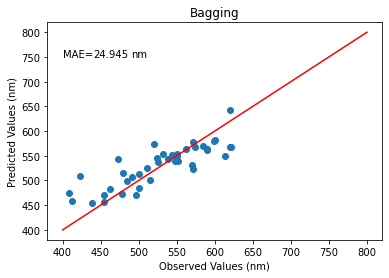

In [184]:
#using grid search parameters
B_regr = BaggingRegressor(bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples=1.0, 
                          n_estimators=48)
B_regr.fit(X_train, np.ravel(Y_train))
            
B_Y_pred = B_regr.predict(X_test)
            
B_mae = mean_absolute_error(Y_test, B_Y_pred)
print("Mean absolute error =", round(B_mae,3), 'nm')

plt.figure()
plt.title("Bagging")
plt.plot(Y_test, B_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(B_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Random Forrest

In [187]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_rf.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_rf.best_score_)
print('Best Parameters : ',rs_rf.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best MAE Score Through Random Search : -38.227
Best Parameters :  {'n_estimators': 678, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'auto', 'bootstrap': True}
CPU times: user 2.95 s, sys: 116 ms, total: 3.07 s
Wall time: 2min 15s


Mean absolute error = 25.619 nm


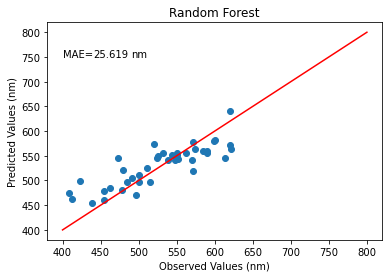

In [190]:
#using grid search parameters
RF_regr = RandomForestRegressor(bootstrap=True, max_features='auto', min_samples_leaf=1, 
                                min_samples_split=2, n_estimators=678)
RF_regr.fit(X_train, np.ravel(Y_train))
            
RF_Y_pred = RF_regr.predict(X_test)
            
RF_mae = mean_absolute_error(Y_test, RF_Y_pred)
print("Mean absolute error =", round(RF_mae,3), 'nm')

plt.figure()
plt.title("Random Forest")
plt.plot(Y_test, RF_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(RF_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Decision Tree

In [ ]:
%%time

#sklearn grid search

params = {"splitter":["best","random"],
          'min_samples_split': [2, 3, 5, 10],
          "min_samples_leaf":[1,2,4,10],
          "min_weight_fraction_leaf":[0.0,0.2,0.5,0.9],
          "max_features":["auto","log2","sqrt",None]}

#n_jobs runs jobs in parallel, verbose prints updates
dt_regressor_grid = GridSearchCV(DecisionTreeRegressor(random_state=45), param_grid=params, n_jobs=-1, verbose=10)
dt_regressor_grid.fit(X_train, np.ravel(Y_train))

print('Best R2 Score Through Grid Search : %.3f'%dt_regressor_grid.best_score_)
print('Best Parameters : ',dt_regressor_grid.best_params_)

Mean absolute error = 28.448 nm


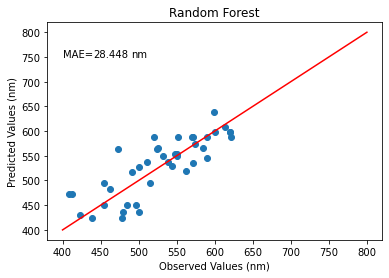

In [166]:
#using grid search parameters
DT_regr = DecisionTreeRegressor(random_state=45, max_features='auto', min_samples_leaf=1, 
                                min_samples_split=10, min_weight_fraction_leaf=0.0, splitter='best')
DT_regr.fit(X_train, np.ravel(Y_train))
            
DT_Y_pred = DT_regr.predict(X_test)
            
DT_mae = mean_absolute_error(Y_test, DT_Y_pred)
print("Mean absolute error =", round(DT_mae,3), 'nm')

plt.figure()
plt.title("Random Forest")
plt.plot(Y_test, DT_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(DT_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Extra Trees

In [ ]:
%%time

#sklearn grid search

params = {"splitter":["best","random"],
          'min_samples_split': [2, 3, 5, 10],
          "min_samples_leaf":[1,2,4,10],
          "min_weight_fraction_leaf":[0.0,0.2,0.5,0.9],
          "max_features":["auto","log2","sqrt",None]}

#n_jobs runs jobs in parallel, verbose prints updates
dt_regressor_grid = GridSearchCV(DecisionTreeRegressor(random_state=45), param_grid=params, n_jobs=-1, verbose=10)
dt_regressor_grid.fit(X_train, np.ravel(Y_train))

print('Best R2 Score Through Grid Search : %.3f'%dt_regressor_grid.best_score_)
print('Best Parameters : ',dt_regressor_grid.best_params_)

In [ ]:
ET_regr = ExtraTreesRegressor(n_estimators=3, max_features=21, random_state=4)
            
ET_regr.fit(X_train, np.ravel(Y_train))
            
ET_Y_pred = ET_regr.predict(X_test)
            
ET_mae = mean_absolute_error(Y_test, ET_Y_pred)
ET_mse = mean_squared_error(Y_test, ET_Y_pred)
print("Mean absolute error =", round(ET_mae,3),'\n',"Mean squared error =", round(ET_mse,3))

plt.figure()
plt.title("Extra TRees")
plt.plot(Y_test, ET_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(ET_mae,3) , fontdict=None)
plt.show()

### Gradient Boosting

In [ ]:
min_mae = 999
min_i, min_j, min_k, min_l = 0, 0, 0.0, 0
for i in tqdm(range(300, 450, 10)):
    for j in range(2, 30, 2):
        for k in np.arange(0.06, 0.22, 0.02):
            for l in range(2, 22, 2):
                GB_regr = GradientBoostingRegressor(n_estimators=i, max_depth=j, learning_rate=k, random_state=l)
                GB_regr.fit(X_train, np.ravel(Y_train))
                GB_Y_pred = GB_regr.predict(X_test)

                mae = mean_absolute_error(Y_test, GB_Y_pred)
                if (min_mae > mae):
                    min_mae = mae
                    min_i = i
                    min_j = j
                    min_k = k
                    min_l = l

print(min_mae, min_i, min_j, min_k, min_l)

In [ ]:
GB_regr = GradientBoostingRegressor(n_estimators=380, max_depth=4, learning_rate=0.18, random_state=6)

            
GB_regr.fit(X_train, np.ravel(Y_train))
            
GB_Y_pred = GB_regr.predict(X_test)
            
GB_mae = mean_absolute_error(Y_test, GB_Y_pred)
print("Mean absolute error =", round(GB_mae,3))

plt.figure()
plt.title("Gradient Boosting")
plt.plot(Y_test, GB_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(GB_mae,3) , fontdict=None)
plt.show()

### Others

In [ ]:
REGRESSIONS = {
    "K-nn": KNeighborsRegressor(),                          
    "Ridge": RidgeCV(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(random_state=0),
                }
# mean absolute error is used to evaluate the performance of all regressions.


for name, reg in REGRESSIONS.items():     
    reg.fit(X_train, Y_train)                 
    Y_pred = pd.DataFrame(reg.predict(X_test))
    
    print(name)
    
    mae = mean_absolute_error(Y_test, Y_pred)
    
    print(' MAE for diameter is ', mae, '\n')

## Conclusion

Extra Trees gave the best performance, **n_estimators=5, max_features=2, random_state=7**

### Saving model

In [ ]:
ET_regr = ExtraTreesRegressor(n_estimators=3, max_features=21, random_state=4)

ET_regr.fit(X_train, np.ravel(Y_train))
ET_Y_pred = ET_regr.predict(X_test)

joblib.dump(ET_regr, "./model_aug_abs_ExtraTrees.joblib")